# HW4 Fall 23 Code

## Q1

Likelihood:

$$
f(x, y | \rho) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(-\frac{1}{2(1 - \rho^2)}(x^2 - 2\rho xy + y^2)\right)
$$

Prior:

$$
\pi(\rho) = \frac{1}{(1 - \rho^2)^{3/2}} \mathbf{1}(-1 \leq \rho \leq 1)
$$

Posterior proportional to:
$$
\begin{align}
\prod_{i=1}^n \left[\frac{1}{\sqrt{1 - \rho^2}} \exp\left(-\frac{1}{2(1 - \rho^2)}(x_i^2 - 2\rho x_i y_i + y_i^2)\right)\right] \frac{1}{(1 - \rho^2)^{3/2}} \mathbf{1}(-1 \leq \rho \leq 1) && \text{Drop constants and take the product of the likelihood from i to n.}\\ 
\left(\frac{1}{\sqrt{1 - \rho^2}}\right)^n \exp\left(-\frac{1}{2(1 - \rho^2)}\sum_{i=1}^n(x_i^2 - 2\rho x_i y_i + y_i^2)\right) \frac{1}{(1 - \rho^2)^{3/2}} \mathbf{1}(-1 \leq \rho \leq 1) && \text{Simplify product.}\\
\frac{1}{(1 - \rho^2)^{3/2}}\left(\frac{1}{\sqrt{1 - \rho^2}}\right)^n \exp\left(-\frac{1}{2(1 - \rho^2)}\sum_{i=1}^n(x_i^2 - 2\rho x_i y_i + y_i^2)\right)  \mathbf{1}(-1 \leq \rho \leq 1) && \text{Combine expressions.}\\
(1 - \rho^2)^{-3/2}\left((1 - \rho^2)^{-1/2}\right)^n \exp\left(-\frac{1}{2(1 - \rho^2)}\sum_{i=1}^n(x_i^2 - 2\rho x_i y_i + y_i^2)\right)  \mathbf{1}(-1 \leq \rho \leq 1) && \text{}\\
(1 - \rho^2)^{-3/2}(1 - \rho^2)^{-n/2} \exp\left(-\frac{1}{2(1 - \rho^2)}\sum_{i=1}^n(x_i^2 - 2\rho x_i y_i + y_i^2)\right)  \mathbf{1}(-1 \leq \rho \leq 1) && \text{}\\
(1 - \rho^2)^{-\frac{1}{2}(n+3)} \exp\left(-\frac{1}{2(1 - \rho^2)}\sum_{i=1}^n(x_i^2 - 2\rho x_i y_i + y_i^2)\right)  \mathbf{1}(-1 \leq \rho \leq 1) && \text{}\\
(1 - \rho^2)^{-\frac{1}{2}(n+3)} \exp\left(-\frac{1}{2(1 - \rho^2)}(\sum_{i=1}^n x_i^2 - 2\rho \sum_{i=1}^n  x_i y_i + \sum_{i=1}^ny_i^2)\right)  \mathbf{1}(-1 \leq \rho \leq 1) && \text{Put sums in correct form to use in part b.}\\
\end{align}
$$
Our proposal is $U(\rho_{i} - .1, \rho_{i} + .1)$ with a density of $\frac{1}{(\rho_{i} + .1) - (\rho_{i} - .1)} = \frac{1}{.2} = 5$. So clearly this will cancel out in the acceptance ratio expression $\frac{q(\rho_{i}|\rho_{*})}{q(\rho_{*}|\rho_{i})}$ since it doesn't depend on any $\rho$.

Then let our acceptance ratio be:

$$
\begin{align}
\text{min}\left(1,\frac{\pi(\rho_{*})}{\pi(p_{i})}\right)
\end{align}
$$
where $\rho_*$ is the proposed $\rho$.

We now have everything we need to code our sampler.

  0%|          | 0/51000 [00:00<?, ?it/s]

np.mean(rho_burned)=0.73766
np.var(rho_burned)=0.001
np.sum(accepted)/n_samples=0.509
95% equitailed credible set: (0.658, 0.801)


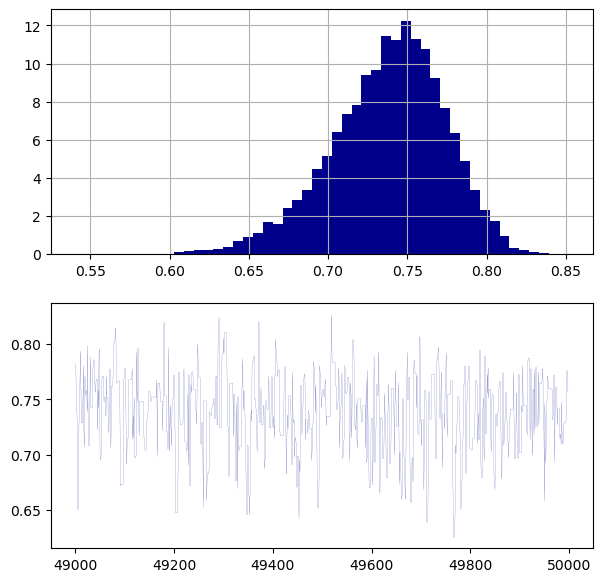

In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

rng = np.random.default_rng(2)
burn = 1000
n_samples = 51000

rho_array = np.zeros(n_samples)
accepted = np.zeros(n_samples)  # for keeping track of accepted %

rho = 0.1  # init

unif = rng.uniform(size=n_samples)


def target(rho):
    sum_x_sq = 115.9707
    sum_y_sq = 105.9196
    sum_xy = 84.5247
    n = 100

    rho_clipped = np.clip(
        rho,
        -0.99999,
        0.99999
    )

    return (1 - rho_clipped**2) ** (-0.5 * (n + 3)) * np.exp(
        -0.5 / (1 - rho_clipped**2) * (sum_x_sq - 2 * rho_clipped * sum_xy + sum_y_sq)
    )


def proposal(rho, rng, part):
    assert part in ["a", "d"]

    if part == "a":
        return rng.uniform(rho - 0.1, rho + 0.1)
    elif part == "d":
        return rng.uniform(-1, 1)


for i in tqdm(range(n_samples)):
    rho_star = proposal(rho, rng, part="a")

    ratio = target(rho_star) / target(rho)
    if unif[i] < min(1, ratio):
        rho = rho_star
        accepted[i] = 1

    rho_array[i] = rho

rho_burned = rho_array[burn:]

print(f"{np.mean(rho_burned)=:.5f}")
print(f"{np.var(rho_burned)=:.3f}")
print(f"{np.sum(accepted)/n_samples=:.3f}")

lower, upper = np.quantile(rho_burned, (0.025, 0.975))
print(f"95% equitailed credible set: ({lower:.3f}, {upper:.3f})")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.grid(True)
ax1.hist(rho_burned, color="darkblue", density=True, bins=50)

ax2.plot(
    range(n_samples - burn * 2, n_samples - burn),
    rho_burned[-burn:],
    color="darkblue",
    linewidth=0.1,
)
plt.show()

  0%|          | 0/51000 [00:00<?, ?it/s]

np.mean(rho_burned)=0.737
np.var(rho_burned)=0.001
np.sum(accepted)/n_samples=0.057
95% equitailed credible set: (0.657, 0.800)


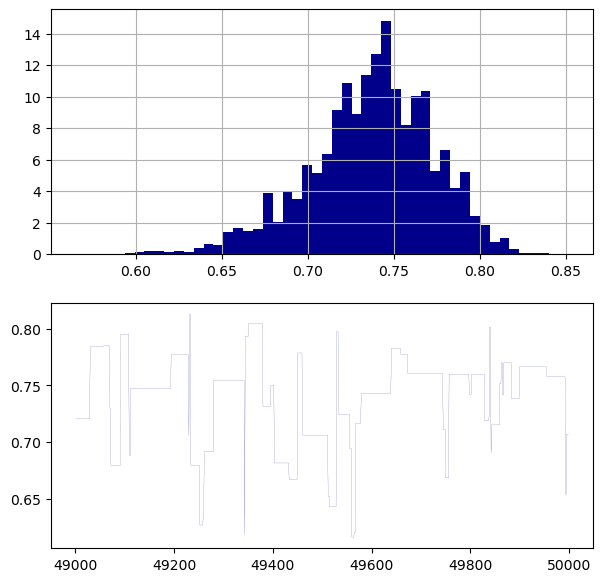

In [2]:
rng = np.random.default_rng(7685)
burn = 1000
n_samples = 51000

rho_array = np.zeros(n_samples)
accepted = np.zeros(n_samples)  # for keeping track of accepted %

rho = 0.1  # init

unif = rng.uniform(size=n_samples)

for i in tqdm(range(n_samples)):
    rho_star = proposal(rho, rng, part="d")

    ratio = target(rho_star) / target(rho)
    if unif[i] < min(1, ratio):
        rho = rho_star
        accepted[i] = 1

    rho_array[i] = rho

rho_burned = rho_array[burn:]

print(f"{np.mean(rho_burned)=:.3f}")
print(f"{np.var(rho_burned)=:.3f}")
print(f"{np.sum(accepted)/n_samples=:.3f}")

lower, upper = np.quantile(rho_burned, (0.025, 0.975))
print(f"95% equitailed credible set: ({lower:.3f}, {upper:.3f})")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.grid(True)
ax1.hist(rho_burned, color="darkblue", density=True, bins=50)

ax2.plot(
    range(n_samples - burn * 2, n_samples - burn),
    rho_burned[-burn:],
    color="darkblue",
    linewidth=0.1,
)
plt.show()

Based on the plots and the accepted percentage, the $U(-1, 1)$ proposal is much less efficient and so has fewer useful samples, although the mean and credible set remain the same. Some people may experience a few divide by zero errors depending on seed and initial value. 


Sometimes a way to make the calculations more computationally stable is to use the log-likelihood as the target instead. In this case it doesn't help, but I'm including that as well.

$$
\begin{align}
\log\left[(1 - \rho^2)^{-\frac{1}{2}(n+3)} \exp\left(-\frac{1}{2(1 - \rho^2)}\left(\sum_{i=1}^n x_i^2 - 2\rho \sum_{i=1}^n  x_i y_i + \sum_{i=1}^n y_i^2\right)\right)\right] \\
\log\left[(1 - \rho^2)^{-\frac{1}{2}(n+3)}\right] + \left(-\frac{1}{2(1 - \rho^2)}\left(\sum_{i=1}^n x_i^2 - 2\rho \sum_{i=1}^n  x_i y_i + \sum_{i=1}^n y_i^2\right)\right) \\
-\frac{1}{2}(n+3)\log\left[(1 - \rho^2)\right] - \frac{1}{2(1 - \rho^2)}\left(\sum_{i=1}^n x_i^2 - 2\rho \sum_{i=1}^n  x_i y_i + \sum_{i=1}^n y_i^2\right)
\end{align}
$$

Log-likelihood version:

  0%|          | 0/51000 [00:00<?, ?it/s]

/var/folders/b8/7kxz8b7579n0gp9kb3wmcf880000gn/T/ipykernel_14876/2993067353.py:28: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(logtarget(rho_star) - logtarget(rho))  # note this difference!


np.mean(rho_burned)=0.73745
np.var(rho_burned)=0.001
np.sum(accepted)/n_samples=0.511
95% equitailed credible set: (0.656, 0.800)


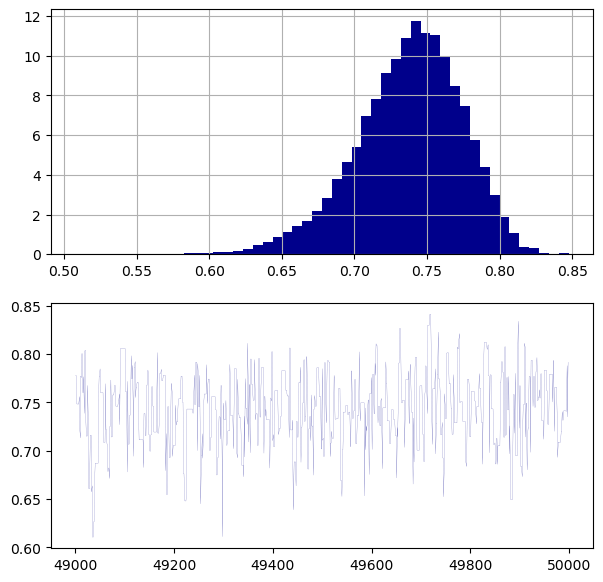

In [3]:
rng = np.random.default_rng(1)
burn = 1000
n_samples = 51000

rho_array = np.zeros(n_samples)
accepted = np.zeros(n_samples)  # for keeping track of accepted %

rho = 1  # init

unif = rng.uniform(size=n_samples)

def logtarget(rho):
    sum_x_sq = 115.9707
    sum_y_sq = 105.9196
    sum_xy = 84.5247
    n = 100

    rho_clipped = np.clip(rho, -0.99999, 0.99999)

    return -0.5 * (n + 3) * np.log(1 - rho_clipped**2) - 0.5 / (
        1 - rho_clipped**2
    ) * (sum_x_sq - 2 * rho_clipped * sum_xy + sum_y_sq)


for i in tqdm(range(n_samples)):
    rho_star = proposal(rho, rng, part="a")

    ratio = np.exp(logtarget(rho_star) - logtarget(rho))  # note this difference!
    if unif[i] < min(1, ratio):
        rho = rho_star
        accepted[i] = 1

    rho_array[i] = rho

rho_burned = rho_array[burn:]

print(f"{np.mean(rho_burned)=:.5f}")
print(f"{np.var(rho_burned)=:.3f}")
print(f"{np.sum(accepted)/n_samples=:.3f}")

lower, upper = np.quantile(rho_burned, (0.025, 0.975))
print(f"95% equitailed credible set: ({lower:.3f}, {upper:.3f})")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.grid(True)
ax1.hist(rho_burned, color="darkblue", density=True, bins=50)

ax2.plot(
    range(n_samples - burn * 2, n_samples - burn),
    rho_burned[-burn:],
    color="darkblue",
    linewidth=0.1,
)
plt.show()

## Q2


$$
\begin{align*}
\quad p(\lambda|\mu, t_1, \ldots, t_n) &\propto \prod_{i=1}^{n} f(t_i|\lambda) \mu(\lambda) \\
&= \lambda^{\exp(-\lambda \sum_{i=1}^{n} t_i)} \lambda^{c-1} \exp(-\alpha \lambda) \\
&= \lambda^{c-1} \exp\left(-\lambda(\alpha + \mu \sum_{i=1}^{n} t_i)\right).
\end{align*}
$$

Hence $\lambda|\mu, t_1, \ldots, t_n$ respects to Gamma distribution with parameters $n+c$ and $\mu \sum_{i=1}^{n} t_i + \alpha$. By symmetry, $\mu|\lambda, t_1, \ldots, t_n$ respects to Gamma distribution with parameters $n + d$ and $\lambda \sum_{i=1}^{n} t_i + \beta$.


  0%|          | 0/21000 [00:00<?, ?it/s]

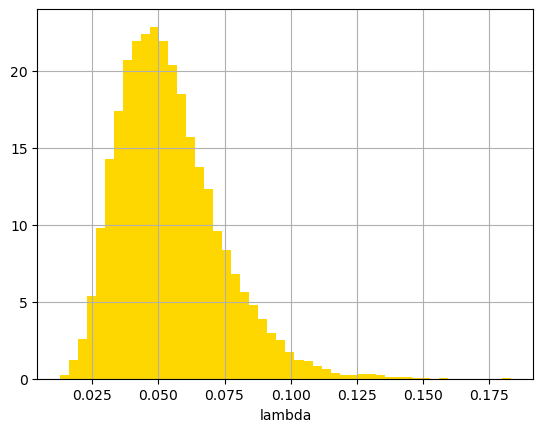

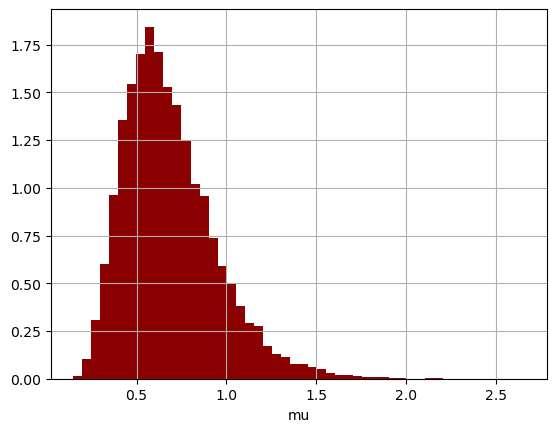

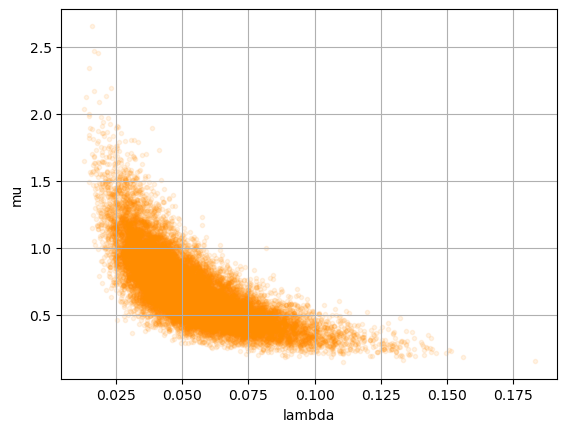

In [10]:
# sampler code
rng = np.random.default_rng(5)
n_samples = 21000
burn = 1000

lam_samples = np.zeros(n_samples)
mu_samples = np.zeros(n_samples)
prod_lam_mu = np.zeros(n_samples)

n = 20
sum_ti = 522
c = 3
d = 1
alpha = 100
beta = 5
mu = 0.1

for i in tqdm(range(n_samples)):
    lam = rng.gamma(shape=n + c, scale=1 / (mu * sum_ti + alpha))
    mu = rng.gamma(shape=n + d, scale=1 / (lam * sum_ti + beta))

    lam_samples[i] = lam
    mu_samples[i] = mu
    prod_lam_mu[i] = lam * mu

lam_burned = lam_samples[burn:]
mu_burned = mu_samples[burn:]
prod_burned = prod_lam_mu[burn:]

plt.hist(lam_burned, bins=50, color="gold", density=True)
plt.xlabel("lambda")
plt.grid(True)
plt.show()

plt.hist(mu_burned, bins=50, color="darkred", density=True)
plt.xlabel("mu")
plt.grid(True)
plt.show()

plt.scatter(lam_burned, mu_burned, color="darkorange", alpha=0.1, marker=".")
plt.xlabel("lambda")
plt.ylabel("mu")
plt.grid(True)
plt.show()

In [11]:
print(f"Mean of lambda: {np.mean(lam_burned):.4f}")
print(f"Variance of lambda: {np.var(lam_burned):.4f}")
lower, upper = np.quantile(lam_burned, (.025, .975))
print(f"Equitailed credible set of lambda: {lower:.4f}, {upper:.4f}")

print(f"Mean of mu: {np.mean(mu_burned):.4f}")
print(f"Variance of mu: {np.var(mu_burned):.4f}")
lower, upper = np.quantile(mu_burned, (.025, .975))
print(f"Equitailed credible set of mu: {lower:.4f}, {upper:.4f}")

Mean of lambda: 0.0543
Variance of lambda: 0.0004
Equitailed credible set of lambda: 0.0254, 0.0985
Mean of mu: 0.6864
Variance of mu: 0.0667
Equitailed credible set of mu: 0.3062, 1.3066


In [12]:
print(f"Mean of mu * lambda {np.mean(prod_burned):4f}")

Mean of mu * lambda 0.033635
